# Load library

In [1]:
#Import lib
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from my_useful_functions import calculate_performance_statistical_parity,calculate_performance_equalized_odds,calculate_performance_equal_opportunity,calculate_performance_predictive_parity,calculate_performance_predictive_equality,calculate_performance_treatment_equality
from sklearn import preprocessing
from aif360.datasets.binary_label_dataset import BinaryLabelDataset
# DT
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
# NB
from sklearn.naive_bayes import GaussianNB
# MLP
from sklearn.neural_network import MLPClassifier
# kNN
from sklearn.neighbors import KNeighborsClassifier
# Adafair
from AdaFair import AdaFair 
# Agarwal
from exponentiated_gradient_reduction import ExponentiatedGradientReduction
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.naive_bayes import GaussianNB
# DIR
from disparate_impact_remover import DisparateImpactRemover
# LFR
from learning_fair_representations import LFR
# EOP
from eq_odds_postprocessing import EqOddsPostprocessing
# CEP
from calibrated_eq_odds_postprocessing import CalibratedEqOddsPostprocessing
from compute_abroca import *
import numpy as np
import sklearn.metrics as metrics 
from scipy import interpolate
from scipy import integrate
import matplotlib.pyplot as plt
import matplotlib
#matplotlib.use('TkAgg')
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

pip install 'aif360[LawSchoolGPA]'
2023-03-27 11:19:56.411804: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-27 11:19:56.411820: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Load Dataset

## PAKDD2010

In [2]:
def load_PAKDD2010():
    df = pd.read_csv('data/PAKDD.csv')    
    protected_attribute = 'SEX'
    majority_group_name = "Male"
    minority_group_name = "Female"
    class_label = 'TARGET_LABEL_BAD' 
    
    print("Length:",len(df))
    print("Number of attribute:",len(df.columns))
    
    #Remove ID
    df=df.drop(columns=['ID_CLIENT'])
    df =df.dropna()
    df=df.drop(columns = ['RESIDENCIAL_PHONE_AREA_CODE','RESIDENCIAL_ZIP_3','PROFESSIONAL_ZIP_3'])
    #Label sex
    df['SEX']=["Female" if v == "F" else "Male" for v in df['SEX']]
    
    
    print("Length (cleaned):",len(df))
    print("Class imbalance: \n",df[class_label].value_counts())
    
    #label encode
    le = preprocessing.LabelEncoder()
    for i in df.columns:
        if df[i].dtypes == 'object':
            df[i] = le.fit_transform(df[i])
    #Splitting data into train and test
    length = len(df.columns)
    X = df.iloc[:,:length-1]
    y = df[class_label]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42) 
    
    #Get index    
    feature = X.keys().tolist()    
    sa_index = feature.index(protected_attribute)
    p_Group = 0 
    
    return X_train, X_test, y_train, y_test,sa_index, p_Group, protected_attribute,majority_group_name,minority_group_name

# Run experiment

In [3]:
def run_experiment(dataset, X_train, X_test, y_train, y_test,sa_index, p_Group,protected_attribute,majority_group_name,minority_group_name, algorithm, preprocessing_algorithm='', postprocessing_algorithm=''):    
    datasetTrain = BinaryLabelDataset(df=pd.concat([X_train, y_train.to_frame()], axis=1), label_names=[y_train.name], protected_attribute_names=[protected_attribute])
    datasetTest = BinaryLabelDataset(df=pd.concat([X_test, y_test.to_frame()], axis=1), label_names=[y_test.name], protected_attribute_names=[protected_attribute])
    
    # preprocessing
    if preprocessing_algorithm != '': 
        if preprocessing_algorithm == 'DIR':
            pre_model = DisparateImpactRemover(sensitive_attribute=protected_attribute)
        elif preprocessing_algorithm == 'LFR':
            privileged_groups = [{protected_attribute: 1.0}]
            unprivileged_groups = [{protected_attribute: 0.0}]
            pre_model = LFR(unprivileged_groups=unprivileged_groups,privileged_groups=privileged_groups)
        dataset_train_transf = pre_model.fit_transform(datasetTrain)
        dataset_test_transf = pre_model.transform(datasetTest)

        X_train_transf = dataset_train_transf.features
        y_train_transf = dataset_train_transf.labels.ravel()
        X_test_transf = dataset_test_transf.features
        y_test_transf= dataset_test_transf.labels.ravel()

        X_train_transf = pd.DataFrame(X_train_transf, columns = X_train.columns)
        y_train_transf = pd.Series(y_train_transf, name = y_train.name).astype(int)
        X_test_transf = pd.DataFrame(X_test_transf, columns = X_train.columns)
        y_test_transf = pd.Series(y_test_transf, name = y_train.name).astype(int)
    
    # inprocessing
    if algorithm == 'DT':
        model = tree.DecisionTreeClassifier(random_state=0)  
    elif algorithm == 'NB': 
        model = GaussianNB()
    elif algorithm == 'MLP':
        model = MLPClassifier(random_state=1, max_iter=300)
    elif algorithm == 'kNN':
        model = KNeighborsClassifier(n_neighbors=5)
    elif algorithm == 'Ada':
        model = AdaFair(n_estimators=50, saIndex=sa_index, saValue=p_Group, CSB="CSB2", c=1, use_validation=False)
    elif algorithm == 'Agar':
        clf =  NB = GaussianNB()
        model = ExponentiatedGradientReduction(prot_attr=protected_attribute,estimator=clf, constraints = "EqualizedOdds")
    
    if preprocessing_algorithm != '':
        model.fit(X_train_transf, y_train_transf)
        y_predicts = model.predict(X_test_transf)
    else:
        model.fit(X_train,y_train)
        y_predicts = model.predict(X_test)

    # postprocessing
    if postprocessing_algorithm != '':
        privileged_groups = [{protected_attribute: 1.0}]
        unprivileged_groups = [{protected_attribute: 0.0}]
        if postprocessing_algorithm == 'EOP':
            post_model = EqOddsPostprocessing(unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups, seed=42)
        if postprocessing_algorithm == 'CEP':
            post_model = CalibratedEqOddsPostprocessing(unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups, seed=42)
        
        y_test_predicts = model.predict(X_test)
        y_train_predicts = model.predict(X_train)

        X_train_predicts = X_train.copy()
        X_test_predicts = X_test.copy()

        X_train_predicts[y_train.name] = y_train_predicts
        X_test_predicts[y_train.name] = y_test_predicts
    
        dataset_train_true = BinaryLabelDataset(df=pd.concat([X_train, y_train.to_frame()], axis=1), label_names=[y_train.name], protected_attribute_names=[protected_attribute])
        dataset_train_predicts = BinaryLabelDataset(df=X_train_predicts, label_names=[y_train.name], protected_attribute_names=[protected_attribute])
        dataset_test_predicts = BinaryLabelDataset(df=X_test_predicts, label_names=[y_test.name], protected_attribute_names=[protected_attribute])

        post_model.fit_predict(dataset_true=dataset_train_true, dataset_pred=dataset_train_predicts)
        dataset_predicts_transf = post_model.predict(dataset_test_predicts)
        data_predicts = dataset_predicts_transf.convert_to_dataframe()[0]
        y_predicts = data_predicts[y_test.name].astype(int)

    print("Statistical parity:")
    print(calculate_performance_statistical_parity(X_test.values, y_test.values, y_predicts, sa_index, p_Group))
         
    print("Equal opportunity")
    print(calculate_performance_equal_opportunity(X_test.values, y_test.values, y_predicts,  sa_index, p_Group))
        
    print("Equalized odds")
    print(calculate_performance_equalized_odds(X_test.values, y_test.values, y_predicts, sa_index, p_Group))
         
    print("Predictive parity")
    print(calculate_performance_predictive_parity(X_test.values, y_test.values, y_predicts,  sa_index, p_Group))
        
    print("Predictive equality")
    print(calculate_performance_predictive_equality(X_test.values, y_test.values, y_predicts,  sa_index, p_Group))
        
    print("Treatment equality")
    print(calculate_performance_treatment_equality(X_test.values, y_test.values, y_predicts,  sa_index, p_Group))
        
    filename = '{}.{}.abroca.pdf'.format(dataset, preprocessing_algorithm+algorithm)
    #make predictions
    if postprocessing_algorithm == '':
        if preprocessing_algorithm:
            X_test['pred_proba'] = model.predict_proba(X_test_transf)[:,1:2]
        else:
            X_test['pred_proba'] = model.predict_proba(X_test)[:,1:2]
        X_test['true_label'] = y_test
        df_test = X_test

        #Compute Abroca
        slice = compute_abroca(df_test, pred_col = 'pred_proba' , label_col = 'true_label', protected_attr_col = protected_attribute,
                            majority_protected_attr_val = 1, n_grid = 10000,
                            plot_slices = True, majority_group_name=majority_group_name ,minority_group_name=minority_group_name,file_name = filename)
        print("ABROCA:",slice)
        plt.clf() 
    plt.clf() 
    

In [4]:
#Main function
def run_eval(dataset, algorithm, preprocessing_algorithm='', postprocessing_algorithm=''):
    if dataset == 'credit-approval':
        X_train, X_test, y_train, y_test,sa_index, p_Group,protected_attribute,majority_group_name,minority_group_name = load_credit_approval()
        run_experiment(dataset, X_train, X_test, y_train, y_test,sa_index, p_Group,protected_attribute,majority_group_name,minority_group_name, algorithm, preprocessing_algorithm, postprocessing_algorithm)                                        
    if dataset == 'credit-card':
        X_train, X_test, y_train, y_test,sa_index, p_Group,protected_attribute,majority_group_name,minority_group_name = load_credit_card()
        run_experiment(dataset, X_train, X_test, y_train, y_test,sa_index, p_Group,protected_attribute,majority_group_name,minority_group_name, algorithm, preprocessing_algorithm, postprocessing_algorithm)                                        
    if dataset == 'german-credit':
        X_train, X_test, y_train, y_test,sa_index, p_Group,protected_attribute,majority_group_name,minority_group_name = load_german_credit()
        run_experiment(dataset, X_train, X_test, y_train, y_test,sa_index, p_Group,protected_attribute,majority_group_name,minority_group_name, algorithm, preprocessing_algorithm, postprocessing_algorithm)                                            
    if dataset == 'PAKDD':
        X_train, X_test, y_train, y_test,sa_index, p_Group,protected_attribute,majority_group_name,minority_group_name = load_PAKDD2010()
        run_experiment(dataset, X_train, X_test, y_train, y_test,sa_index, p_Group,protected_attribute,majority_group_name,minority_group_name, algorithm, preprocessing_algorithm, postprocessing_algorithm)                                                                
    if dataset == 'credit-scoring':
        X_train, X_test, y_train, y_test,sa_index, p_Group,protected_attribute,majority_group_name,minority_group_name = load_credit_scoring()
        run_experiment(dataset, X_train, X_test, y_train, y_test,sa_index, p_Group,protected_attribute,majority_group_name,minority_group_name, algorithm, preprocessing_algorithm, postprocessing_algorithm)                                                                        
    if dataset == 'application':
        X_train, X_test, y_train, y_test,sa_index, p_Group,protected_attribute,majority_group_name,minority_group_name = load_application()
        run_experiment(dataset, X_train, X_test, y_train, y_test,sa_index, p_Group,protected_attribute,majority_group_name,minority_group_name, algorithm, preprocessing_algorithm, postprocessing_algorithm)                                                                       

## PAKDD

Length: 50000
Number of attribute: 47
Length (cleaned): 38896
Class imbalance: 
 0    28747
1    10149
Name: TARGET_LABEL_BAD, dtype: int64
Statistical parity:
{'balanced_accuracy': 0.5241417021523852, 'accuracy': 0.6243894078327191, 'f1-score': 0.3048374306106265, 'fairness': 0.012434346153057163}
Equal opportunity
{'balanced_accuracy': 0.5241417021523852, 'accuracy': 0.6243894078327191, 'f1-score': 0.3048374306106265, 'fairness': 0.03251140367944311, 'TPR_protected': 0.29768467475192945, 'TPR_non_protected': 0.33019607843137255, 'TNR_protected': 0.7384267971396311, 'TNR_non_protected': 0.7351500306184936}
Equalized odds
{'balanced_accuracy': 0.5241417021523852, 'accuracy': 0.6243894078327191, 'f1-score': 0.3048374306106265, 'fairness': 0.035788170200580616, 'TPR_protected': 0.29768467475192945, 'TPR_non_protected': 0.33019607843137255, 'TNR_protected': 0.7384267971396311, 'TNR_non_protected': 0.7351500306184936}
Predictive parity
{'balanced_accuracy': 0.5241417021523852, 'accuracy': 

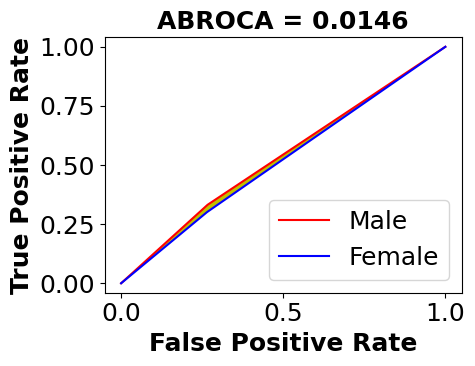

ABROCA: 0.014617318596370573


<Figure size 640x480 with 0 Axes>

In [5]:
run_eval(dataset='PAKDD', algorithm='DT')

Length: 50000
Number of attribute: 47
Length (cleaned): 38896
Class imbalance: 
 0    28747
1    10149
Name: TARGET_LABEL_BAD, dtype: int64
Statistical parity:
{'balanced_accuracy': 0.5088497722197949, 'accuracy': 0.7255977375953381, 'f1-score': 0.08514285714285713, 'fairness': 0.0021843320033880093}
Equal opportunity
{'balanced_accuracy': 0.5088497722197949, 'accuracy': 0.7255977375953381, 'f1-score': 0.08514285714285713, 'fairness': 0.008681929221523228, 'TPR_protected': 0.05181918412348401, 'TPR_non_protected': 0.043137254901960784, 'TNR_protected': 0.9715844937899887, 'TNR_non_protected': 0.9660134721371708}
Equalized odds
{'balanced_accuracy': 0.5088497722197949, 'accuracy': 0.7255977375953381, 'f1-score': 0.08514285714285713, 'fairness': 0.014252950874341093, 'TPR_protected': 0.05181918412348401, 'TPR_non_protected': 0.043137254901960784, 'TNR_protected': 0.9715844937899887, 'TNR_non_protected': 0.9660134721371708}
Predictive parity
{'balanced_accuracy': 0.5088497722197949, 'accu

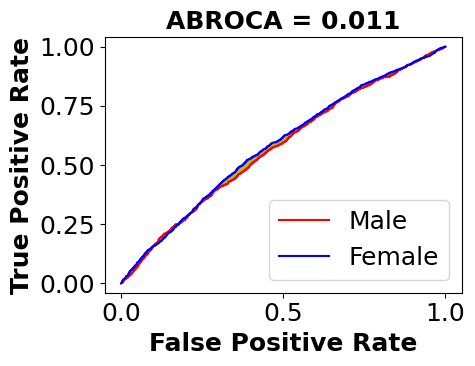

ABROCA: 0.01097816825640374


<Figure size 640x480 with 0 Axes>

In [6]:
run_eval(dataset='PAKDD', algorithm='NB')

Length: 50000
Number of attribute: 47
Length (cleaned): 38896
Class imbalance: 
 0    28747
1    10149
Name: TARGET_LABEL_BAD, dtype: int64
Statistical parity:
{'balanced_accuracy': 0.5119422365699478, 'accuracy': 0.692518639129317, 'f1-score': 0.18082191780821918, 'fairness': 0.06547048823896802}
Equal opportunity
{'balanced_accuracy': 0.5119422365699478, 'accuracy': 0.692518639129317, 'f1-score': 0.18082191780821918, 'fairness': 0.07151912143027002, 'TPR_protected': 0.09867695700110253, 'TPR_non_protected': 0.17019607843137255, 'TNR_protected': 0.9194580353782461, 'TNR_non_protected': 0.8570116350275566}
Equalized odds
{'balanced_accuracy': 0.5119422365699478, 'accuracy': 0.692518639129317, 'f1-score': 0.18082191780821918, 'fairness': 0.1339655217809595, 'TPR_protected': 0.09867695700110253, 'TPR_non_protected': 0.17019607843137255, 'TNR_protected': 0.9194580353782461, 'TNR_non_protected': 0.8570116350275566}
Predictive parity
{'balanced_accuracy': 0.5119422365699478, 'accuracy': 0.6

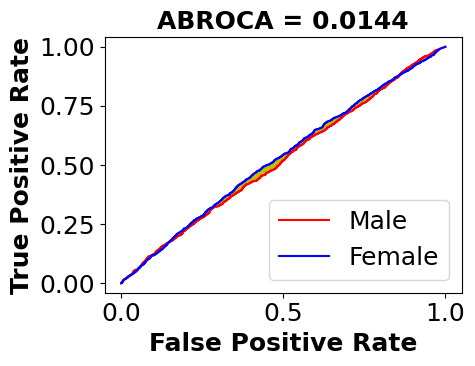

ABROCA: 0.014386588818127653


<Figure size 640x480 with 0 Axes>

In [7]:
run_eval(dataset='PAKDD', algorithm='MLP')

Length: 50000
Number of attribute: 47
Length (cleaned): 38896
Class imbalance: 
 0    28747
1    10149
Name: TARGET_LABEL_BAD, dtype: int64
Statistical parity:
{'balanced_accuracy': 0.5056743569369014, 'accuracy': 0.6822349815751135, 'f1-score': 0.17855560478511298, 'fairness': -0.005602218569259604}
Equal opportunity
{'balanced_accuracy': 0.5056743569369014, 'accuracy': 0.6822349815751135, 'f1-score': 0.17855560478511298, 'fairness': 0.01915256069351666, 'TPR_protected': 0.13836824696802646, 'TPR_non_protected': 0.1192156862745098, 'TNR_protected': 0.8805043281896876, 'TNR_non_protected': 0.8815064298836497}
Equalized odds
{'balanced_accuracy': 0.5056743569369014, 'accuracy': 0.6822349815751135, 'f1-score': 0.17855560478511298, 'fairness': 0.020154662387478747, 'TPR_protected': 0.13836824696802646, 'TPR_non_protected': 0.1192156862745098, 'TNR_protected': 0.8805043281896876, 'TNR_non_protected': 0.8815064298836497}
Predictive parity
{'balanced_accuracy': 0.5056743569369014, 'accuracy'

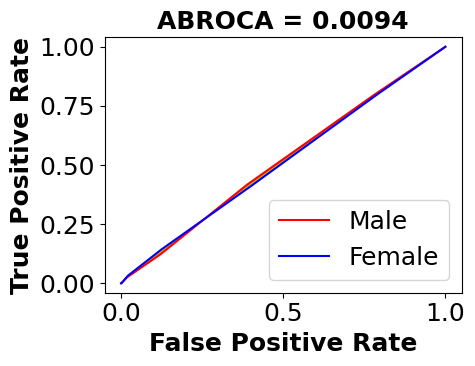

ABROCA: 0.009406464147531489


<Figure size 640x480 with 0 Axes>

In [8]:
run_eval(dataset='PAKDD', algorithm='kNN')

Length: 50000
Number of attribute: 47
Length (cleaned): 38896
Class imbalance: 
 0    28747
1    10149
Name: TARGET_LABEL_BAD, dtype: int64
Statistical parity:
{'balanced_accuracy': 0.5, 'accuracy': 0.7352815151255463, 'f1-score': 0.0, 'fairness': 0.0}
Equal opportunity
{'balanced_accuracy': 0.5, 'accuracy': 0.7352815151255463, 'f1-score': 0.0, 'fairness': 0.0, 'TPR_protected': 0.0, 'TPR_non_protected': 0.0, 'TNR_protected': 1.0, 'TNR_non_protected': 1.0}
Equalized odds
{'balanced_accuracy': 0.5, 'accuracy': 0.7352815151255463, 'f1-score': 0.0, 'fairness': 0.0, 'TPR_protected': 0.0, 'TPR_non_protected': 0.0, 'TNR_protected': 1.0, 'TNR_non_protected': 1.0}
Predictive parity
{'balanced_accuracy': 0.5, 'accuracy': 0.7352815151255463, 'f1-score': 0.0, 'fairness': 0.0, 'TPR_protected': 0.0, 'TPR_non_protected': 0.0, 'TNR_protected': 1.0, 'TNR_non_protected': 1.0}
Predictive equality
{'balanced_accuracy': 0.5, 'accuracy': 0.7352815151255463, 'f1-score': 0.0, 'fairness': 0.0, 'TPR_protected':

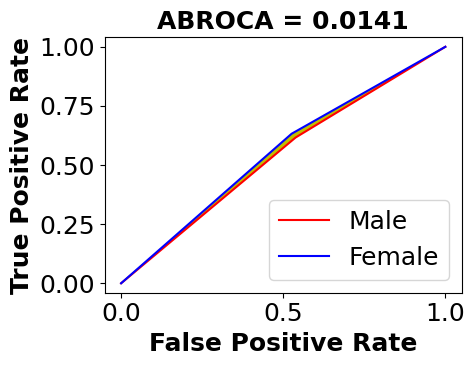

ABROCA: 0.01413606234849289


<Figure size 640x480 with 0 Axes>

In [9]:
run_eval(dataset='PAKDD', algorithm='Ada')

Length: 50000
Number of attribute: 47
Length (cleaned): 38896
Class imbalance: 
 0    28747
1    10149
Name: TARGET_LABEL_BAD, dtype: int64
Statistical parity:
{'balanced_accuracy': 0.5093159726859954, 'accuracy': 0.7262833147656184, 'f1-score': 0.08533791523482244, 'fairness': -0.0017404401992965474}
Equal opportunity
{'balanced_accuracy': 0.5093159726859954, 'accuracy': 0.7262833147656184, 'f1-score': 0.08533791523482244, 'fairness': 0.014024255788313122, 'TPR_protected': 0.05402425578831312, 'TPR_non_protected': 0.04, 'TNR_protected': 0.9712081294693263, 'TNR_non_protected': 0.9690753214941825}
Equalized odds
{'balanced_accuracy': 0.5093159726859954, 'accuracy': 0.7262833147656184, 'f1-score': 0.08533791523482244, 'fairness': 0.016157063763456936, 'TPR_protected': 0.05402425578831312, 'TPR_non_protected': 0.04, 'TNR_protected': 0.9712081294693263, 'TNR_non_protected': 0.9690753214941825}
Predictive parity
{'balanced_accuracy': 0.5093159726859954, 'accuracy': 0.7262833147656184, 'f1-

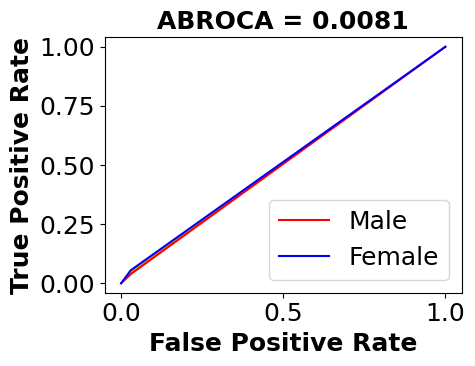

ABROCA: 0.008078530935840671


<Figure size 640x480 with 0 Axes>

In [10]:
run_eval(dataset='PAKDD', algorithm='Agar')

In [11]:
run_eval(dataset='PAKDD', algorithm='DT', preprocessing_algorithm='DIR')

Length: 50000
Number of attribute: 47
Length (cleaned): 38896
Class imbalance: 
 0    28747
1    10149
Name: TARGET_LABEL_BAD, dtype: int64
Statistical parity:
{'balanced_accuracy': 0.5174079993600874, 'accuracy': 0.6189047904704773, 'f1-score': 0.2953573126287435, 'fairness': 0.025291884812548404}
Equal opportunity
{'balanced_accuracy': 0.5174079993600874, 'accuracy': 0.6189047904704773, 'f1-score': 0.2953573126287435, 'fairness': 0.011603000626932147, 'TPR_protected': 0.3065049614112459, 'TPR_non_protected': 0.29490196078431374, 'TNR_protected': 0.7474595408355288, 'TNR_non_protected': 0.709736680955297}
Equalized odds
{'balanced_accuracy': 0.5174079993600874, 'accuracy': 0.6189047904704773, 'f1-score': 0.2953573126287435, 'fairness': 0.04932586050716398, 'TPR_protected': 0.3065049614112459, 'TPR_non_protected': 0.29490196078431374, 'TNR_protected': 0.7474595408355288, 'TNR_non_protected': 0.709736680955297}
Predictive parity
{'balanced_accuracy': 0.5174079993600874, 'accuracy': 0.61

In [12]:
run_eval(dataset='PAKDD', algorithm='NB', preprocessing_algorithm='DIR')

Length: 50000
Number of attribute: 47
Length (cleaned): 38896
Class imbalance: 
 0    28747
1    10149
Name: TARGET_LABEL_BAD, dtype: int64
Statistical parity:
{'balanced_accuracy': 0.512954192672548, 'accuracy': 0.7209700916959465, 'f1-score': 0.11857065511640498, 'fairness': 0.025078280418513843}
Equal opportunity
{'balanced_accuracy': 0.512954192672548, 'accuracy': 0.7209700916959465, 'f1-score': 0.11857065511640498, 'fairness': 0.015501653803748627, 'TPR_protected': 0.06449834619625137, 'TPR_non_protected': 0.08, 'TNR_protected': 0.9655626646593903, 'TNR_non_protected': 0.9378444580526638}
Equalized odds
{'balanced_accuracy': 0.512954192672548, 'accuracy': 0.7209700916959465, 'f1-score': 0.11857065511640498, 'fairness': 0.04321986041047515, 'TPR_protected': 0.06449834619625137, 'TPR_non_protected': 0.08, 'TNR_protected': 0.9655626646593903, 'TNR_non_protected': 0.9378444580526638}
Predictive parity
{'balanced_accuracy': 0.512954192672548, 'accuracy': 0.7209700916959465, 'f1-score':

In [13]:
run_eval(dataset='PAKDD', algorithm='MLP', preprocessing_algorithm='DIR')

Length: 50000
Number of attribute: 47
Length (cleaned): 38896
Class imbalance: 
 0    28747
1    10149
Name: TARGET_LABEL_BAD, dtype: int64
Statistical parity:
{'balanced_accuracy': 0.5002978083748559, 'accuracy': 0.7351101208329762, 'f1-score': 0.0025814778960955146, 'fairness': 3.911240423021972e-05}
Equal opportunity
{'balanced_accuracy': 0.5002978083748559, 'accuracy': 0.7351101208329762, 'f1-score': 0.0025814778960955146, 'fairness': 0.0018016732602633113, 'TPR_protected': 0.0005512679162072767, 'TPR_non_protected': 0.002352941176470588, 'TNR_protected': 0.999059089198344, 'TNR_non_protected': 0.9996938150642989}
Equalized odds
{'balanced_accuracy': 0.5002978083748559, 'accuracy': 0.7351101208329762, 'f1-score': 0.0025814778960955146, 'fairness': 0.0024363991262182326, 'TPR_protected': 0.0005512679162072767, 'TPR_non_protected': 0.002352941176470588, 'TNR_protected': 0.999059089198344, 'TNR_non_protected': 0.9996938150642989}
Predictive parity
{'balanced_accuracy': 0.5002978083748

In [14]:
run_eval(dataset='PAKDD', algorithm='kNN', preprocessing_algorithm='DIR')

Length: 50000
Number of attribute: 47
Length (cleaned): 38896
Class imbalance: 
 0    28747
1    10149
Name: TARGET_LABEL_BAD, dtype: int64
Statistical parity:
{'balanced_accuracy': 0.5026831240411688, 'accuracy': 0.6810352215271231, 'f1-score': 0.1703076237182345, 'fairness': -0.00275557082978356}
Equal opportunity
{'balanced_accuracy': 0.5026831240411688, 'accuracy': 0.6810352215271231, 'f1-score': 0.1703076237182345, 'fairness': 0.0044443003221134175, 'TPR_protected': 0.12183020948180816, 'TPR_non_protected': 0.12627450980392158, 'TNR_protected': 0.8795634173880316, 'TNR_non_protected': 0.8851806491120637}
Equalized odds
{'balanced_accuracy': 0.5026831240411688, 'accuracy': 0.6810352215271231, 'f1-score': 0.1703076237182345, 'fairness': 0.010061532046145585, 'TPR_protected': 0.12183020948180816, 'TPR_non_protected': 0.12627450980392158, 'TNR_protected': 0.8795634173880316, 'TNR_non_protected': 0.8851806491120637}
Predictive parity
{'balanced_accuracy': 0.5026831240411688, 'accuracy'

In [16]:
run_eval(dataset='PAKDD', algorithm='DT', preprocessing_algorithm='LFR')

Length: 50000
Number of attribute: 47
Length (cleaned): 38896
Class imbalance: 
 0    28747
1    10149
Name: TARGET_LABEL_BAD, dtype: int64
Statistical parity:
{'balanced_accuracy': 0.4949101103924672, 'accuracy': 0.7200274230868112, 'f1-score': 0.030276046304541407, 'fairness': 0.006863269213705975}
Equal opportunity
{'balanced_accuracy': 0.4949101103924672, 'accuracy': 0.7200274230868112, 'f1-score': 0.030276046304541407, 'fairness': 0.001268132390773287, 'TPR_protected': 0.015986769570011026, 'TPR_non_protected': 0.017254901960784313, 'TNR_protected': 0.9768535942792623, 'TNR_non_protected': 0.9675443968156767}
Equalized odds
{'balanced_accuracy': 0.4949101103924672, 'accuracy': 0.7200274230868112, 'f1-score': 0.030276046304541407, 'fairness': 0.010577329854358893, 'TPR_protected': 0.015986769570011026, 'TPR_non_protected': 0.017254901960784313, 'TNR_protected': 0.9768535942792623, 'TNR_non_protected': 0.9675443968156767}
Predictive parity
{'balanced_accuracy': 0.4949101103924672, '

Length: 50000
Number of attribute: 47
Length (cleaned): 38896
Class imbalance: 
 0    28747
1    10149
Name: TARGET_LABEL_BAD, dtype: int64
Statistical parity:
{'balanced_accuracy': 0.503373991930159, 'accuracy': 0.27714457108578283, 'f1-score': 0.41887702376851527, 'fairness': -0.008809497505085861}
Equal opportunity
{'balanced_accuracy': 0.503373991930159, 'accuracy': 0.27714457108578283, 'f1-score': 0.41887702376851527, 'fairness': 0.006377413148280331, 'TPR_protected': 0.9867695700110254, 'TPR_non_protected': 0.9803921568627451, 'TNR_protected': 0.01881821603312006, 'TNR_non_protected': 0.02878138395590937}
Equalized odds
{'balanced_accuracy': 0.503373991930159, 'accuracy': 0.27714457108578283, 'f1-score': 0.41887702376851527, 'fairness': 0.01634058107106964, 'TPR_protected': 0.9867695700110254, 'TPR_non_protected': 0.9803921568627451, 'TNR_protected': 0.01881821603312006, 'TNR_non_protected': 0.02878138395590937}
Predictive parity
{'balanced_accuracy': 0.503373991930159, 'accuracy

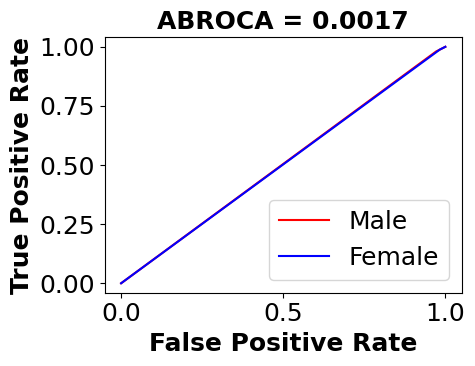

ABROCA: 0.0016931390358262252


<Figure size 640x480 with 0 Axes>

In [6]:
run_eval(dataset='PAKDD', algorithm='NB', preprocessing_algorithm='LFR')

Length: 50000
Number of attribute: 47
Length (cleaned): 38896
Class imbalance: 
 0    28747
1    10149
Name: TARGET_LABEL_BAD, dtype: int64
Statistical parity:
{'balanced_accuracy': 0.49858740051359024, 'accuracy': 0.7179706915759705, 'f1-score': 0.05729017473503295, 'fairness': 0.003446958266014273}
Equal opportunity
{'balanced_accuracy': 0.49858740051359024, 'accuracy': 0.7179706915759705, 'f1-score': 0.05729017473503295, 'fairness': 0.007045852519618652, 'TPR_protected': 0.03528114663726571, 'TPR_non_protected': 0.02823529411764706, 'TNR_protected': 0.9676326684230335, 'TNR_non_protected': 0.9601959583588487}
Equalized odds
{'balanced_accuracy': 0.49858740051359024, 'accuracy': 0.7179706915759705, 'f1-score': 0.05729017473503295, 'fairness': 0.014482562583803434, 'TPR_protected': 0.03528114663726571, 'TPR_non_protected': 0.02823529411764706, 'TNR_protected': 0.9676326684230335, 'TNR_non_protected': 0.9601959583588487}
Predictive parity
{'balanced_accuracy': 0.49858740051359024, 'acc

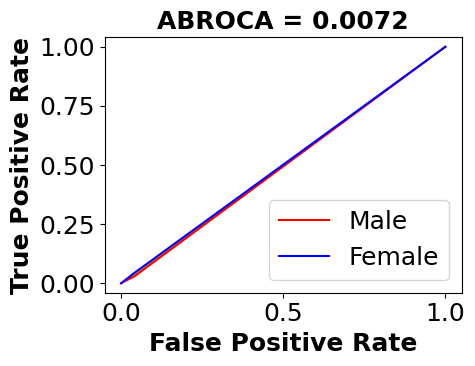

ABROCA: 0.007241281138105948


<Figure size 640x480 with 0 Axes>

In [7]:
run_eval(dataset='PAKDD', algorithm='MLP', preprocessing_algorithm='LFR')

Length: 50000
Number of attribute: 47
Length (cleaned): 38896
Class imbalance: 
 0    28747
1    10149
Name: TARGET_LABEL_BAD, dtype: int64
Statistical parity:
{'balanced_accuracy': 0.5075116719904678, 'accuracy': 0.4736481275173537, 'f1-score': 0.3682369882740177, 'fairness': 0.021184557162315265}
Equal opportunity
{'balanced_accuracy': 0.5075116719904678, 'accuracy': 0.4736481275173537, 'f1-score': 0.3682369882740177, 'fairness': 0.002445900079987906, 'TPR_protected': 0.5804851157662624, 'TPR_non_protected': 0.5780392156862745, 'TNR_protected': 0.4467444486262702, 'TNR_non_protected': 0.41733006736068584}
Equalized odds
{'balanced_accuracy': 0.5075116719904678, 'accuracy': 0.4736481275173537, 'f1-score': 0.3682369882740177, 'fairness': 0.03186028134557228, 'TPR_protected': 0.5804851157662624, 'TPR_non_protected': 0.5780392156862745, 'TNR_protected': 0.4467444486262702, 'TNR_non_protected': 0.41733006736068584}
Predictive parity
{'balanced_accuracy': 0.5075116719904678, 'accuracy': 0.

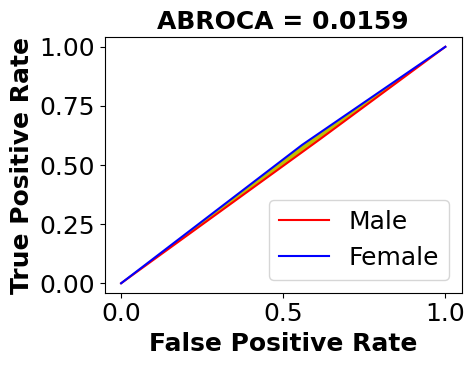

ABROCA: 0.015930140348013665


<Figure size 640x480 with 0 Axes>

In [9]:
run_eval(dataset='PAKDD', algorithm='kNN', preprocessing_algorithm='LFR')

In [10]:
run_eval(dataset='PAKDD', algorithm='DT', postprocessing_algorithm='EOP')

Length: 50000
Number of attribute: 47
Length (cleaned): 38896
Class imbalance: 
 0    28747
1    10149
Name: TARGET_LABEL_BAD, dtype: int64
Statistical parity:
{'balanced_accuracy': 0.5241417021523852, 'accuracy': 0.6243894078327191, 'f1-score': 0.3048374306106265, 'fairness': 0.012434346153057163}
Equal opportunity
{'balanced_accuracy': 0.5241417021523852, 'accuracy': 0.6243894078327191, 'f1-score': 0.3048374306106265, 'fairness': 0.03251140367944311, 'TPR_protected': 0.29768467475192945, 'TPR_non_protected': 0.33019607843137255, 'TNR_protected': 0.7384267971396311, 'TNR_non_protected': 0.7351500306184936}
Equalized odds
{'balanced_accuracy': 0.5241417021523852, 'accuracy': 0.6243894078327191, 'f1-score': 0.3048374306106265, 'fairness': 0.035788170200580616, 'TPR_protected': 0.29768467475192945, 'TPR_non_protected': 0.33019607843137255, 'TNR_protected': 0.7384267971396311, 'TNR_non_protected': 0.7351500306184936}
Predictive parity
{'balanced_accuracy': 0.5241417021523852, 'accuracy': 

<Figure size 640x480 with 0 Axes>

In [11]:
run_eval(dataset='PAKDD', algorithm='NB', postprocessing_algorithm='EOP')

Length: 50000
Number of attribute: 47
Length (cleaned): 38896
Class imbalance: 
 0    28747
1    10149
Name: TARGET_LABEL_BAD, dtype: int64
Statistical parity:
{'balanced_accuracy': 0.5083447845992359, 'accuracy': 0.7257691318879081, 'f1-score': 0.08204245553643144, 'fairness': -0.0008986893575457094}
Equal opportunity
{'balanced_accuracy': 0.5083447845992359, 'accuracy': 0.7257691318879081, 'f1-score': 0.08204245553643144, 'fairness': 0.013387811574464406, 'TPR_protected': 0.05181918412348401, 'TPR_non_protected': 0.038431372549019606, 'TNR_protected': 0.9715844937899887, 'TNR_non_protected': 0.9684629516227802}
Equalized odds
{'balanced_accuracy': 0.5083447845992359, 'accuracy': 0.7257691318879081, 'f1-score': 0.08204245553643144, 'fairness': 0.016509353741672908, 'TPR_protected': 0.05181918412348401, 'TPR_non_protected': 0.038431372549019606, 'TNR_protected': 0.9715844937899887, 'TNR_non_protected': 0.9684629516227802}
Predictive parity
{'balanced_accuracy': 0.5083447845992359, 'acc

<Figure size 640x480 with 0 Axes>

In [12]:

run_eval(dataset='PAKDD', algorithm='MLP', postprocessing_algorithm='EOP')

Length: 50000
Number of attribute: 47
Length (cleaned): 38896
Class imbalance: 
 0    28747
1    10149
Name: TARGET_LABEL_BAD, dtype: int64
Statistical parity:
{'balanced_accuracy': 0.5132171944813577, 'accuracy': 0.6854057759876596, 'f1-score': 0.198646583715346, 'fairness': 0.012036301748553108}
Equal opportunity
{'balanced_accuracy': 0.5132171944813577, 'accuracy': 0.6854057759876596, 'f1-score': 0.198646583715346, 'fairness': 0.01228268154009124, 'TPR_protected': 0.1422271223814774, 'TPR_non_protected': 0.15450980392156863, 'TNR_protected': 0.8833270605946556, 'TNR_non_protected': 0.8723208818126148}
Equalized odds
{'balanced_accuracy': 0.5132171944813577, 'accuracy': 0.6854057759876596, 'f1-score': 0.198646583715346, 'fairness': 0.023288860322132038, 'TPR_protected': 0.1422271223814774, 'TPR_non_protected': 0.15450980392156863, 'TNR_protected': 0.8833270605946556, 'TNR_non_protected': 0.8723208818126148}
Predictive parity
{'balanced_accuracy': 0.5132171944813577, 'accuracy': 0.685

<Figure size 640x480 with 0 Axes>

In [13]:
run_eval(dataset='PAKDD', algorithm='kNN', postprocessing_algorithm='EOP')

Length: 50000
Number of attribute: 47
Length (cleaned): 38896
Class imbalance: 
 0    28747
1    10149
Name: TARGET_LABEL_BAD, dtype: int64
Statistical parity:
{'balanced_accuracy': 0.5057390650786572, 'accuracy': 0.6817207986974034, 'f1-score': 0.17977031802120141, 'fairness': -0.0075663038666782395}
Equal opportunity
{'balanced_accuracy': 0.5057390650786572, 'accuracy': 0.6817207986974034, 'f1-score': 0.17977031802120141, 'fairness': 0.02135763235834577, 'TPR_protected': 0.14057331863285558, 'TPR_non_protected': 0.1192156862745098, 'TNR_protected': 0.8786225065863756, 'TNR_non_protected': 0.8815064298836497}
Equalized odds
{'balanced_accuracy': 0.5057390650786572, 'accuracy': 0.6817207986974034, 'f1-score': 0.17977031802120141, 'fairness': 0.02424155565561982, 'TPR_protected': 0.14057331863285558, 'TPR_non_protected': 0.1192156862745098, 'TNR_protected': 0.8786225065863756, 'TNR_non_protected': 0.8815064298836497}
Predictive parity
{'balanced_accuracy': 0.5057390650786572, 'accuracy'

<Figure size 640x480 with 0 Axes>

In [14]:
run_eval(dataset='PAKDD', algorithm='DT', postprocessing_algorithm='CEP')

Length: 50000
Number of attribute: 47
Length (cleaned): 38896
Class imbalance: 
 0    28747
1    10149
Name: TARGET_LABEL_BAD, dtype: int64
Statistical parity:
{'balanced_accuracy': 0.5241417021523852, 'accuracy': 0.6243894078327191, 'f1-score': 0.3048374306106265, 'fairness': 0.012434346153057163}
Equal opportunity
{'balanced_accuracy': 0.5241417021523852, 'accuracy': 0.6243894078327191, 'f1-score': 0.3048374306106265, 'fairness': 0.03251140367944311, 'TPR_protected': 0.29768467475192945, 'TPR_non_protected': 0.33019607843137255, 'TNR_protected': 0.7384267971396311, 'TNR_non_protected': 0.7351500306184936}
Equalized odds
{'balanced_accuracy': 0.5241417021523852, 'accuracy': 0.6243894078327191, 'f1-score': 0.3048374306106265, 'fairness': 0.035788170200580616, 'TPR_protected': 0.29768467475192945, 'TPR_non_protected': 0.33019607843137255, 'TNR_protected': 0.7384267971396311, 'TNR_non_protected': 0.7351500306184936}
Predictive parity
{'balanced_accuracy': 0.5241417021523852, 'accuracy': 

<Figure size 640x480 with 0 Axes>

In [15]:
run_eval(dataset='PAKDD', algorithm='NB', postprocessing_algorithm='CEP')

Length: 50000
Number of attribute: 47
Length (cleaned): 38896
Class imbalance: 
 0    28747
1    10149
Name: TARGET_LABEL_BAD, dtype: int64
Statistical parity:
{'balanced_accuracy': 0.508791591488257, 'accuracy': 0.7268831947896135, 'f1-score': 0.08076146524372657, 'fairness': 0.006813961633017642}
Equal opportunity
{'balanced_accuracy': 0.508791591488257, 'accuracy': 0.7268831947896135, 'f1-score': 0.08076146524372657, 'fairness': 0.0037205179756577417, 'TPR_protected': 0.046857772877618525, 'TPR_non_protected': 0.043137254901960784, 'TNR_protected': 0.9761008656379375, 'TNR_non_protected': 0.9660134721371708}
Equalized odds
{'balanced_accuracy': 0.508791591488257, 'accuracy': 0.7268831947896135, 'f1-score': 0.08076146524372657, 'fairness': 0.013807911476424448, 'TPR_protected': 0.046857772877618525, 'TPR_non_protected': 0.043137254901960784, 'TNR_protected': 0.9761008656379375, 'TNR_non_protected': 0.9660134721371708}
Predictive parity
{'balanced_accuracy': 0.508791591488257, 'accura

<Figure size 640x480 with 0 Axes>

In [16]:
run_eval(dataset='PAKDD', algorithm='MLP', postprocessing_algorithm='CEP')

Length: 50000
Number of attribute: 47
Length (cleaned): 38896
Class imbalance: 
 0    28747
1    10149
Name: TARGET_LABEL_BAD, dtype: int64
Statistical parity:
{'balanced_accuracy': 0.5126745516272871, 'accuracy': 0.7028879938298055, 'f1-score': 0.16195310611554264, 'fairness': 0.09956139732987712}
Equal opportunity
{'balanced_accuracy': 0.5126745516272871, 'accuracy': 0.7028879938298055, 'f1-score': 0.16195310611554264, 'fairness': 0.10514646431891389, 'TPR_protected': 0.06504961411245866, 'TPR_non_protected': 0.17019607843137255, 'TNR_protected': 0.9537071885585247, 'TNR_non_protected': 0.8570116350275566}
Equalized odds
{'balanced_accuracy': 0.5126745516272871, 'accuracy': 0.7028879938298055, 'f1-score': 0.16195310611554264, 'fairness': 0.20184201784988193, 'TPR_protected': 0.06504961411245866, 'TPR_non_protected': 0.17019607843137255, 'TNR_protected': 0.9537071885585247, 'TNR_non_protected': 0.8570116350275566}
Predictive parity
{'balanced_accuracy': 0.5126745516272871, 'accuracy':

<Figure size 640x480 with 0 Axes>

In [17]:
run_eval(dataset='PAKDD', algorithm='kNN', postprocessing_algorithm='CEP')

Length: 50000
Number of attribute: 47
Length (cleaned): 38896
Class imbalance: 
 0    28747
1    10149
Name: TARGET_LABEL_BAD, dtype: int64
Statistical parity:
{'balanced_accuracy': 0.5060177628565456, 'accuracy': 0.6860913531579398, 'f1-score': 0.17220338983050848, 'fairness': 0.0068837522500445475}
Equal opportunity
{'balanced_accuracy': 0.5060177628565456, 'accuracy': 0.6860913531579398, 'f1-score': 0.17220338983050848, 'fairness': 0.007024666536956561, 'TPR_protected': 0.12624035281146637, 'TPR_non_protected': 0.1192156862745098, 'TNR_protected': 0.8931125329318781, 'TNR_non_protected': 0.8815064298836497}
Equalized odds
{'balanced_accuracy': 0.5060177628565456, 'accuracy': 0.6860913531579398, 'f1-score': 0.17220338983050848, 'fairness': 0.01863076958518496, 'TPR_protected': 0.12624035281146637, 'TPR_non_protected': 0.1192156862745098, 'TNR_protected': 0.8931125329318781, 'TNR_non_protected': 0.8815064298836497}
Predictive parity
{'balanced_accuracy': 0.5060177628565456, 'accuracy'

<Figure size 640x480 with 0 Axes>